# ASSIGNMENT 3: Investigating by seasons

by Daniel Horton, Feb 2017; mod to Python: Irene Crisologo, July 2019

daniel.horton@northwestern.edu

**Objectives:**

Use the WACCM netCDF file to

(1) create a 2006-2099 annual average global Mollweide map plot, 

(2) create a time series line plot of annual average global temperature weighted by latitude, 

(3) create a time series line plot of global average temperature anomalies weighted by latitude with a baseline of 2006-2035, and 

(4) repeat steps 2 and 3 for each season (Spring: March-April-May, Summer: June-July-August, Autumn: Sept-Oct-Nov, Winter: Dec-Jab-Feb) with each season in a subplot.


### Import libraries
In this exercise, we need the following libraries:

* xarray for reading the data file
* matplotlib for plotting
* numpy for numerical functions
* math for mathematical operations
* cftime for handling the CF time format

In [9]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import math
import cftime
import cartopy.crs as ccrs

from mpl_toolkits.axes_grid1 import make_axes_locatable

### Define functions

The global averages must be weighted by latitude. At the moment, `xarray` does not have a built-in function for weighted averaging ([though this feature seems to be close to being included...](https://github.com/pydata/xarray/issues/422)), so here is a function [created/suggested by an xarray user](https://github.com/pydata/xarray/issues/2713) for weighted averaging...

In [10]:
def weighted_mean(data_da, dim, weights):
    r"""Computes the weighted mean.

    We can only do the actual weighted mean over the dimensions that
    ``data_da`` and ``weights`` share, so for dimensions in ``dim`` that aren't
    included in ``weights`` we must take the unweighted mean.

    This functions skips NaNs, i.e. Data points that are NaN have corresponding
    NaN weights.

    Args:
        data_da (xarray.DataArray):
            Data to compute a weighted mean for.
        dim (str | list[str]):
            dimension(s) of the dataarray to reduce over
        weights (xarray.DataArray):
            a 1-D dataarray the same length as the weighted dim, with dimension
            name equal to that of the weighted dim. Must be nonnegative.
    Returns:
        (xarray.DataArray):
            The mean over the given dimension. So it will contain all
            dimensions of the input that are not in ``dim``.
    Raises:
        (IndexError):
            If ``weights.dims`` is not a subset of ``dim``.
        (ValueError):
            If ``weights`` has values that are negative or infinite.
    """
    if isinstance(dim, str):
        dim = [dim]
    else:
        dim = list(dim)

    if not set(weights.dims) <= set(dim):
        dim_err_msg = (
            "`weights.dims` must be a subset of `dim`. {} are dimensions in "
            "`weights`, but not in `dim`."
        ).format(set(weights.dims) - set(dim))
        raise IndexError(dim_err_msg)
    else:
        pass  # `weights.dims` is a subset of `dim`

    if (weights < 0).any() or xr.ufuncs.isinf(weights).any():
        negative_weight_err_msg = "Weight must be nonnegative and finite"
        raise ValueError(negative_weight_err_msg)
    else:
        pass  # `weights` are nonnegative

    weight_dims = [
        weight_dim for weight_dim in dim if weight_dim in weights.dims
    ]

    if np.isnan(data_da).any():
        expanded_weights, _ = xr.broadcast(weights, data_da)
        weights_with_nans = expanded_weights.where(~np.isnan(data_da))
    else:
        weights_with_nans = weights

    mean_da = ((data_da * weights_with_nans).sum(weight_dims, skipna=True)
               / weights_with_nans.sum(weight_dims))
    other_dims = list(set(dim) - set(weight_dims))
    return mean_da.mean(other_dims, skipna=True)

### Reading the file

Set the filename.

In [11]:
fname = '/projects/b1045/cmip/CMIP5/NCL_Practice/tas_Amon_CESM1-WACCM_rcp85_r2i1p1_200601-209912.nc'

Use `xarray` to read the file. 

In [12]:
DS=xr.open_dataset(fname)

### Task 1:  Create a 2006-2099 annual average global Mollweide map plot

Get the data within the given time period and get the global mean.

In [13]:
data_2006_2099=DS.sel(time=slice('2006-01-01','2099-12-31'))
data_2006_2099_tas_mean=data_2006_2099.tas.mean(dim='time')

Extract the coordinates variables from the dataset.

In [14]:
lat = data_2006_2099.lat # latitude
lon = data_2006_2099.lon # longitude

Set the map projection and data coordinate reference system.

In [39]:
# #Projection for plot
# projection= ccrs.Mollweide(central_longitude=255);
# # Data projection  -- these are different!
# data_crs = ccrs.PlateCarree()

#Projection for plot
projection= ccrs.PlateCarree()
# Data projection  -- these are different!
data_crs = ccrs.PlateCarree()

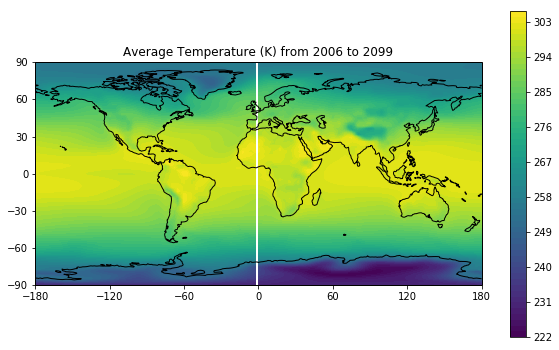

In [40]:
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=projection)
ax.set_global()
ax.coastlines()
cf=ax.contourf(lon, lat, data_2006_2099_tas_mean, levels=60, transform=data_crs, cbar_kwargs={'label': DS.tas.units})
plt.colorbar(cf)
ax.set_label(DS.tas.units)
ax.set_xticks([-180,-120,-60,0, 60, 120, 180], crs= projection)
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs= projection)
#ax.gridlines(crs=data_crs,linestyle="dotted")
plt.title("Average Temperature (K) from 2006 to 2099")
plt.show()

Text(0.5, 1.0, 'Temperature')

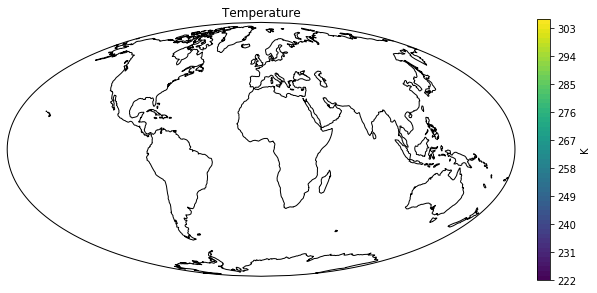

In [14]:
# Open figure object
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=projection)
ax.set_global()
ax.coastlines()

cf=ax.contourf(lon, lat, data_2006_2099_tas_mean, levels=60, transform=data_crs, cbar_kwargs={'label': DS.tas.units})
cb = plt.colorbar(cf, fraction=0.05, pad=0.04, shrink=0.8)
cb.set_label(DS.tas.units)

plt.title("Temperature")

### Task 2: Create a time series line plot of annual average global temperature weighted by latitude

Similar to the steps in Assignment 2.

In [9]:
rad  = 4.*math.atan(1.)/180.
weights_lat   = np.cos(lat*rad)

In [10]:
wmean_lat = weighted_mean(data_2006_2099.tas, dim='lat', weights=weights_lat)
wmean = wmean_lat.mean(dim='lon')
annual_wmean = wmean.groupby('time.year').mean(dim='time')

Text(0.0, 1.0, 'Global Annual Mean Temperatures')

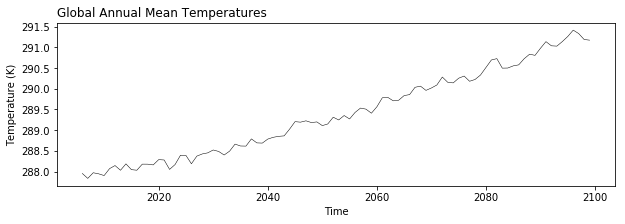

In [11]:
plt.figure(figsize=(10,3))
plt.plot(annual_wmean.year, annual_wmean.data, linestyle='-', color='black', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.title('Global Annual Mean Temperatures', loc='left')

### Task 3: Create a time series line plot of global average temperature anomalies weighted by latitude with a baseline of 2006-2035

In [12]:
baseline = wmean.sel(time=slice('2006-01-01','2035-12-31')).mean(dim='time')

In [13]:
anomaly = annual_wmean - baseline

Text(0.0, 1.0, 'Global Annual Temperature Anomaly')

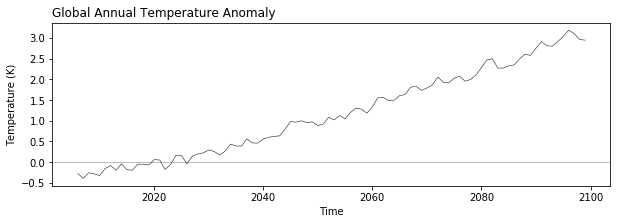

In [14]:
plt.figure(figsize=(10,3))
plt.plot(anomaly.year, anomaly.data, linestyle='-', color='black', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.axhline(y=0, color='0.5', linewidth=0.5, zorder=-10)
plt.title('Global Annual Temperature Anomaly', loc='left')

### Task 4: Repeat steps 2 and 3 for each season (Spring: March-April-May, Summer: June-July-August, Autumn: Sept-Oct-Nov, Winter: Dec-Jab-Feb) with each season in a subplot

To accomplish this, first let's resample ng dataset into seasons. This [offset aliases reference](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases) discusses all about the different time frequencies that we can resample the dataset. Since we want to resample the dataset by seasons, where DJF season belongs to the succeeding year, we use the `Q-FEB` offset alias. `Q` means quarterly, and `FEB` means it ends in Feb. 

In [15]:
wmean_seasonal = wmean.resample(time='Q-FEB').mean()

This gives us a quarterly mean where each associated time step is the last month of the season.

In [16]:
print(wmean_seasonal.time)

<xarray.DataArray 'time' (time: 377)>
array([cftime.DatetimeNoLeap(2006, 2, 28, 0, 0, 0, 0, 6, 59),
       cftime.DatetimeNoLeap(2006, 5, 31, 0, 0, 0, 0, 0, 151),
       cftime.DatetimeNoLeap(2006, 8, 31, 0, 0, 0, 0, 1, 243), ...,
       cftime.DatetimeNoLeap(2099, 8, 31, 0, 0, 0, 0, 3, 243),
       cftime.DatetimeNoLeap(2099, 11, 30, 0, 0, 0, 0, 3, 334),
       cftime.DatetimeNoLeap(2100, 2, 28, 0, 0, 0, 0, 2, 59)], dtype=object)
Coordinates:
  * time     (time) object 2006-02-28 00:00:00 ... 2100-02-28 00:00:00
    height   float64 2.0


To separate each season, we can select it by the month it ends.

In [17]:
wmean_DJF = wmean_seasonal.sel(time=wmean_seasonal.time.dt.month==2) # 2 for FEB
wmean_MAM = wmean_seasonal.sel(time=wmean_seasonal.time.dt.month==5) # 5 for MAY
wmean_JJA = wmean_seasonal.sel(time=wmean_seasonal.time.dt.month==8) # 8 for AUG
wmean_SON = wmean_seasonal.sel(time=wmean_seasonal.time.dt.month==11) # 11 for SEP

In [18]:
wmean_DJF_time = wmean_DJF.indexes['time'].to_datetimeindex()
wmean_MAM_time = wmean_MAM.indexes['time'].to_datetimeindex()
wmean_JJA_time = wmean_JJA.indexes['time'].to_datetimeindex()
wmean_SON_time = wmean_SON.indexes['time'].to_datetimeindex()

/home/iac6311/.conda/envs/tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  """Entry point for launching an IPython kernel.
/home/iac6311/.conda/envs/tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  
/home/iac6311/.conda/envs/tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  

/home/iac6311/.conda/envs/tutorial/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


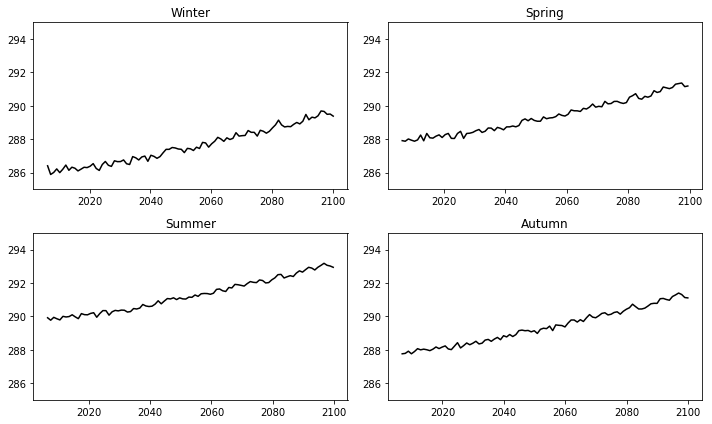

In [19]:
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(10,6))

# winter
ax1.plot(wmean_DJF_time, wmean_DJF.data, color='k')
ax1.set_title('Winter')
# spring
ax2.plot(wmean_MAM_time, wmean_MAM.data, color='k')
ax2.set_title('Spring')
# summer
ax3.plot(wmean_JJA_time, wmean_JJA.data, color='k')
ax3.set_title('Summer')
# autumn
ax4.plot(wmean_SON_time, wmean_SON.data, color='k')
ax4.set_title('Autumn')

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_ylim((285,295))
    
plt.tight_layout()

In [20]:
baseline_DJF = wmean_DJF.sel(time=slice('2006-01-01','2035-12-31')).mean(dim='time')
baseline_MAM = wmean_MAM.sel(time=slice('2006-01-01','2035-12-31')).mean(dim='time')
baseline_JJA = wmean_JJA.sel(time=slice('2006-01-01','2035-12-31')).mean(dim='time')
baseline_SON = wmean_SON.sel(time=slice('2006-01-01','2035-12-31')).mean(dim='time')

In [21]:
anomaly_DJF = wmean_DJF - baseline_DJF
anomaly_MAM = wmean_MAM - baseline_MAM
anomaly_JJA = wmean_JJA - baseline_JJA
anomaly_SON = wmean_SON - baseline_SON

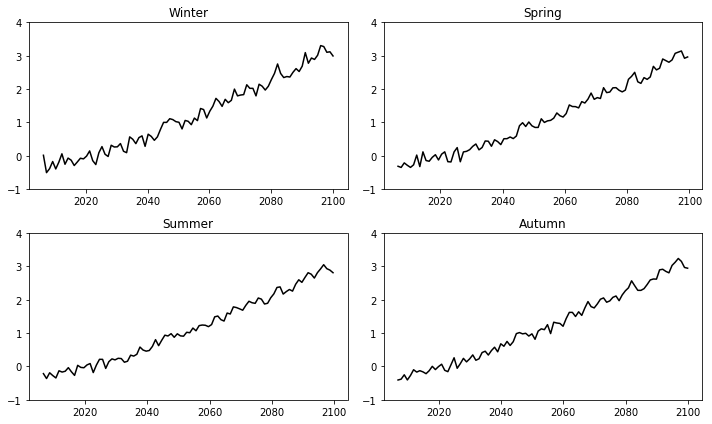

In [22]:
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(10,6))

# winter
ax1.plot(wmean_DJF_time, anomaly_DJF.data, color='k')
ax1.set_title('Winter')
# spring
ax2.plot(wmean_MAM_time, anomaly_MAM.data, color='k')
ax2.set_title('Spring')
# summer
ax3.plot(wmean_JJA_time, anomaly_JJA.data, color='k')
ax3.set_title('Summer')
# autumn
ax4.plot(wmean_SON_time, anomaly_SON.data, color='k')
ax4.set_title('Autumn')

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_ylim((-1,4))
    
plt.tight_layout()

### Extra

Text(0.0, 1.0, 'Global Annual Temperature Anomaly per season')

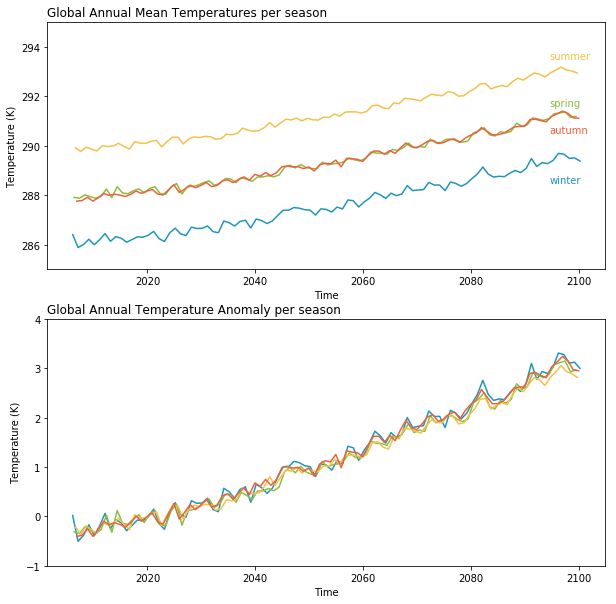

In [40]:
fig, [ax1,ax2] = plt.subplots(nrows=2, ncols=1, figsize=(10,10))

ax1.plot(wmean_DJF_time, wmean_DJF.data, linestyle='-', color='#1e95bc')
ax1.plot(wmean_MAM_time, wmean_MAM.data, linestyle='-', color='#8cbd3f')
ax1.plot(wmean_JJA_time, wmean_JJA.data, linestyle='-', color='#f4c04a')
ax1.plot(wmean_SON_time, wmean_SON.data, linestyle='-', color='#ec613c')
ax1.set_ylim((285,295))
ax1.set_xlabel('Time')
ax1.set_ylabel('Temperature (K)')
ax1.set_title('Global Annual Mean Temperatures per season', loc='left')
ax1.annotate('summer',xy=(0.9,0.85),xycoords='axes fraction', color='#f4c04a')
ax1.annotate('spring',xy=(0.9,0.66),xycoords='axes fraction', color='#8cbd3f')
ax1.annotate('autumn',xy=(0.9,0.55),xycoords='axes fraction', color='#ec613c')
ax1.annotate('winter',xy=(0.9,0.35),xycoords='axes fraction', color='#1e95bc')

ax2.plot(wmean_DJF_time, anomaly_DJF.data, color='#1e95bc')
ax2.plot(wmean_MAM_time, anomaly_MAM.data, color='#8cbd3f')
ax2.plot(wmean_JJA_time, anomaly_JJA.data, color='#f4c04a')
ax2.plot(wmean_SON_time, anomaly_SON.data, color='#ec613c')
ax2.set_ylim((-1,4))
ax2.set_xlabel('Time')
ax2.set_ylabel('Temperature (K)')
ax2.set_title('Global Annual Temperature Anomaly per season', loc='left')